## 1. Requirements

In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set Args

In [26]:
eps = 0.5
use_cuda = True

## 3. Prepare Data

In [4]:
# # https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
# class_idx = json.load(open("./data/imagenet_class_index.json"))
# idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
# transform = transforms.Compose([
#     transforms.Resize((299, 299)),
#     transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
# ])

In [ ]:
# def image_folder_custom_label(root, transform, custom_label) :
    
#     # custom_label
#     # type : List
#     # index -> label
#     # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
#     old_data = dsets.ImageFolder(root = root, transform = transform)
#     old_classes = old_data.classes
    
#     label2idx = {}
    
#     for i, item in enumerate(idx2label) :
#         label2idx[item] = i
    
#     new_data = dsets.ImageFolder(root = root, transform = transform, 
#                                  target_transform = lambda x : custom_label.index(old_classes[x]))
#     new_data.classes = idx2label
#     new_data.class_to_idx = label2idx

#     return new_data

In [ ]:
# normal_data = image_folder_custom_label(root = './data/', transform = transform, custom_label = idx2label)
# normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

In [7]:
def cifar10_loader(batch_size):
    train_transforms = transforms.Compose([
                                        transforms.RandomResizedCrop(32) ,
                                        transforms.ToTensor()  ,
                                        transforms.Normalize( mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ])

    val_transforms = transforms.Compose([
                                        transforms.Resize(32) ,
                                        transforms.ToTensor()  ,
                                        transforms.Normalize( mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ])
    train_data = torchvision.datasets.CIFAR10('data/train',train=True,download=True, transform=train_transforms)
    val_data = torchvision.datasets.CIFAR10('data/val',train=False,download=True, transform=val_transforms)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,num_workers=4)

    return train_loader, val_loader, train_data, val_data



In [8]:
normal_train_loader, normal_val_loader, normal_train_data, normal_val_data = cifar10_loader(1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/train/cifar-10-python.tar.gz to data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/val/cifar-10-python.tar.gz to data/val


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


True Image & True Label


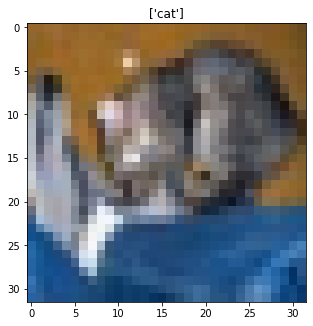

In [10]:
normal_iter = iter(normal_val_loader)
images, labels = normal_iter.next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_val_data.classes[i] for i in labels])

## 4. Download the Resnet18

In [11]:
'''ResNet in PyTorch.
BasicBlock and Bottleneck module is from the original ResNet paper:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
PreActBlock and PreActBottleneck module is from the later paper:
[2] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, lin=0, lout=5):
        out = x
        if lin < 1 and lout > -1:
            out = self.conv1(out)
            out = self.bn1(out)
            out = F.relu(out)
        if lin < 2 and lout > 0:
            out = self.layer1(out)
        if lin < 3 and lout > 1:
            out = self.layer2(out)
        if lin < 4 and lout > 2:
            out = self.layer3(out)
        if lin < 5 and lout > 3:
            out = self.layer4(out)
        if lout > 4:
            out = F.avg_pool2d(out, 4)
            out = out.view(out.size(0), -1)
            out = self.linear(out)
        return out


def ResNet18():
    return ResNet(PreActBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


def test():
    net = ResNet18()
    y = net(Variable(torch.randn(1,3,32,32)))
    print(y.size())

In [12]:
device = torch.device("cuda" if use_cuda else "cpu")

In [13]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [14]:
!ls 'gdrive/MyDrive/Mixup/resnet18/resnet18_exp1.ckpt'

gdrive/MyDrive/Mixup/resnet18/resnet18_exp1.ckpt


In [15]:
resnet1_path = 'gdrive/MyDrive/Mixup/resnet18/resnet18_exp1.ckpt'
resnet2_path = 'gdrive/MyDrive/Mixup/resnet18/resnet18_exp2.ckpt'
resnet_mixup_path= 'gdrive/MyDrive/Mixup/resnet18_mixup/resnet18_mixup.ckpt'


# 5. White Box Adversarial Attack

In [16]:
def fgsm_attack(model, loss, images, labels, eps) :
    
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True
            
    outputs = model(images)
    
    model.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

In [17]:
loss = nn.CrossEntropyLoss()

### model 1

In [19]:
ckpt = torch.load(resnet1_path)
ckpt['best_val_acc']
model_stat = ckpt['model_sate_dict']
model1 = ResNet18()
model1.load_state_dict(model_stat)
model1=model1.to(device)

In [50]:
normal_train_loader, normal_val_loader, normal_train_data, normal_val_data = cifar10_loader(1)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print("True Image & Predicted Label")

model1.eval()

correct = 0
total = 0

for images, labels in normal_val_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model1(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    # imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_val_data.classes[i] for i in pre])
        
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

True Image & Predicted Label


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of test text: 95.090000 %


In [37]:
print("Attack Image & Predicted Label")

model1.eval()

correct = 0
total = 0
eps=0.007
for images, labels in normal_val_loader:
    
    images = fgsm_attack(model1, loss, images, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model1(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    # imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

Attack Image & Predicted Label


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of test text: 56.250000 %


In [51]:
print("Attack Image & Predicted Label")

model1.eval()

correct = 0
total = 0
eps=0.007
for images, labels in normal_val_loader:
  for i in range(10):
      images = fgsm_attack(model1, loss, images, labels, eps).to(device)
      images=images.detach()
  labels = labels.to(device)
  outputs = model1(images)
  
  _, pre = torch.max(outputs.data, 1)
  
  total += 1
  correct += (pre == labels).sum()
      
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

Attack Image & Predicted Label


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of test text: 0.040000 %


### model 2

In [22]:
ckpt = torch.load(resnet2_path)
print(ckpt['best_val_acc'])
model_stat = ckpt['model_sate_dict']
model2 = ResNet18()
model2.load_state_dict(model_stat)
model2=model2.to(device)

94.61


In [52]:
normal_train_loader, normal_val_loader, normal_train_data, normal_val_data = cifar10_loader(1)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [39]:
print("Attack Image & Predicted Label")

model2.eval()

correct = 0
total = 0
eps=0.007
for images, labels in normal_val_loader:
    
    images = fgsm_attack(model2, loss, images, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model2(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

Attack Image & Predicted Label


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of test text: 51.580000 %


##model 3 (mixup)

In [24]:
ckpt = torch.load(resnet_mixup_path)
ckpt['best_val_acc']
model_stat = ckpt['model_sate_dict']
model_mixup = ResNet18()
model_mixup.load_state_dict(model_stat)
model_mixup = model_mixup.to(device)

In [42]:
normal_train_loader, normal_val_loader, normal_train_data, normal_val_data = cifar10_loader(1)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print("Attack Image & Predicted Label")

model_mixup.eval()

correct = 0
total = 0
eps=0.007
for images, labels in normal_val_loader:
  for i in range(10):
      images = fgsm_attack(model_mixup, loss, images, labels, eps).to(device)
      images=images.detach()

  labels = labels.to(device)
  outputs = model_mixup(images)
  
  _, pre = torch.max(outputs.data, 1)
  
  total += 1
  correct += (pre == labels).sum()
  
      
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

In [49]:
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

Accuracy of test text: 1.250000 %


# Black Box Attack

In [ ]:
ckpt = torch.load(resnet1_path)
ckpt['best_val_acc']
model_stat = ckpt['model_sate_dict']
black_box_model = ResNet18()
black_box_model.load_state_dict(model_stat)
black_box_model=model.to(device)

## Model1 ==> Model2:

In [33]:
print("Attack Image & Predicted Label")

model1.eval()
model2.eval()
correct = 0
total = 0

eps=0.007
for images, labels in normal_val_loader:
    
    images = fgsm_attack(model1, loss, images, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model2(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    
print(f'eps: {eps} Accuracy of test text: %f %%' % (100 * float(correct) / total))

eps=0.5
for images, labels in normal_val_loader:
    
    images = fgsm_attack(model1, loss, images, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model2(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    
print(f'eps: {eps} Accuracy of test text: %f %%' % (100 * float(correct) / total))

eps=4
for images, labels in normal_val_loader:
    
    images = fgsm_attack(model1, loss, images, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model2(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    
print(f'eps: {eps} Accuracy of test text: %f %%' % (100 * float(correct) / total))

Attack Image & Predicted Label


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


eps: 0.007 Accuracy of test text: 52.360000 %
eps: 0.5 Accuracy of test text: 36.675000 %
eps: 4 Accuracy of test text: 27.473333 %


In [53]:
normal_train_loader, normal_val_loader, normal_train_data, normal_val_data = cifar10_loader(1)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [54]:
print("Attack Image & Predicted Label")

model1.eval()
model2.eval()

correct = 0
total = 0
eps=0.007
for images, labels in normal_val_loader:
  for i in range(10):
      images = fgsm_attack(model1, loss, images, labels, eps).to(device)
      images=images.detach()
  labels = labels.to(device)
  outputs = model2(images)
  
  _, pre = torch.max(outputs.data, 1)
  
  total += 1
  correct += (pre == labels).sum()
      
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

Attack Image & Predicted Label


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of test text: 3.550000 %


#Model1 ==> Mixup

In [35]:
print("Attack Image & Predicted Label")

model1.eval()
model_mixup.eval()
correct = 0
total = 0

eps=0.007
for images, labels in normal_val_loader:
    
    images = fgsm_attack(model1, loss, images, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model_mixup(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    
print(f'eps: {eps} Accuracy of test text: %f %%' % (100 * float(correct) / total))


eps=0.5
for images, labels in normal_val_loader:
    
    images = fgsm_attack(model1, loss, images, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model_mixup(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    
print(f'eps: {eps} Accuracy of test text: %f %%' % (100 * float(correct) / total))


eps=4
for images, labels in normal_val_loader:
    
    images = fgsm_attack(model1, loss, images, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model_mixup(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    
print(f'eps: {eps} Accuracy of test text: %f %%' % (100 * float(correct) / total))

Attack Image & Predicted Label


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


eps: 0.007 Accuracy of test text: 46.450000 %
eps: 0.5 Accuracy of test text: 32.150000 %
eps: 4 Accuracy of test text: 24.223333 %


In [ ]:
normal_train_loader, normal_val_loader, normal_train_data, normal_val_data = cifar10_loader(1)

In [55]:
print("Attack Image & Predicted Label")

model1.eval()
model_mixup.eval()

correct = 0
total = 0
eps=0.007
for images, labels in normal_val_loader:
  for i in range(10):
      images = fgsm_attack(model1, loss, images, labels, eps).to(device)
      images=images.detach()
  labels = labels.to(device)
  outputs = model_mixup(images)
  
  _, pre = torch.max(outputs.data, 1)
  
  total += 1
  correct += (pre == labels).sum()
      
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

Attack Image & Predicted Label


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of test text: 8.400000 %


In [ ]:
torchvision.datasets.

In [ ]:
!wget https://post.medicalnewstoday.com/wp-content/uploads/sites/3/2020/02/322868_1100-800x825.jpg

In [ ]:
!wget https://static.toiimg.com/thumb/msid-67586673,width-800,height-600,resizemode-75,imgsize-3918697,pt-32,y_pad-40/67586673.jpg

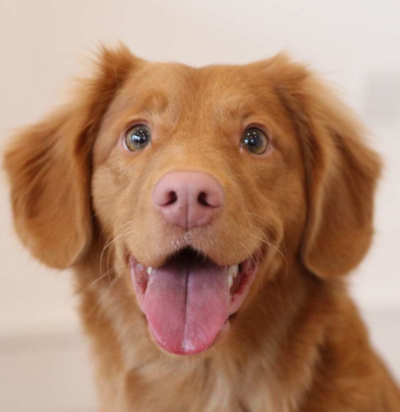

In [ ]:
from PIL import Image
dog = Image.open('dog.jpg')
transforms.ToPILImage()( transforms.ToTensor()( transforms.Resize(400)(dog) ))

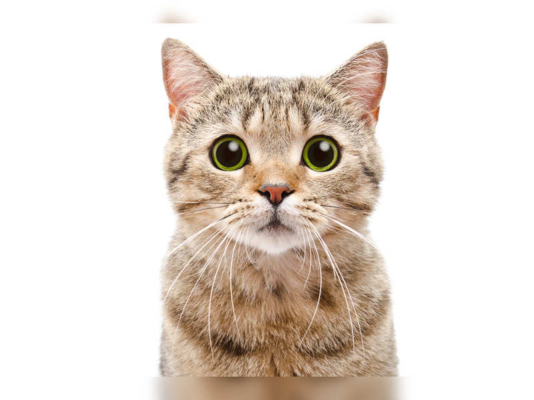

In [ ]:
cat = Image.open('cat.jpg')
transforms.ToPILImage()( transforms.ToTensor()( transforms.Resize(400)(cat) ))

In [ ]:
dog = transforms.ToTensor()( transforms.Resize((400,400))(dog) )
cat = transforms.ToTensor()( transforms.Resize((400,400))(cat) ) 

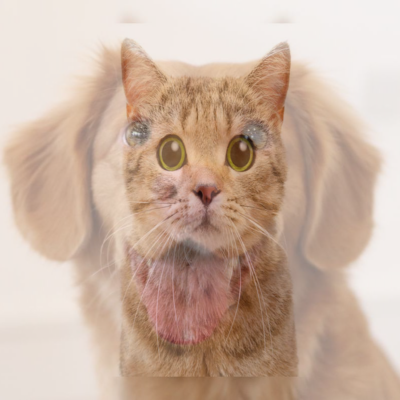

In [ ]:
mix = transforms.ToPILImage()(dog*0.5 + cat*0.5)
mix